In [1]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import math
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
data = pd.read_csv('tesla.csv')

In [3]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/2/2015,222.869995,223.250000,213.259995,219.309998,219.309998,4764400
1,1/5/2015,214.550003,216.500000,207.160004,210.089996,210.089996,5368500
2,1/6/2015,210.059998,214.199997,204.210007,211.279999,211.279999,6261900
3,1/7/2015,213.350006,214.779999,209.779999,210.949997,210.949997,2968400
4,1/8/2015,212.809998,213.800003,210.009995,210.619995,210.619995,3442500


In [4]:
data.shape

(1404, 7)

In [5]:
data = data.iloc[:,4:5]

In [6]:
data.head()

,Close
0,219.309998
1,210.089996
2,211.279999
3,210.949997
4,210.619995


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1404 entries, 0 to 1403
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1404 non-null   float64
dtypes: float64(1)
memory usage: 11.1 KB


In [8]:
train_df = data.iloc[:1000,:].values

In [9]:
train_df.shape

(1000, 1)

In [10]:
scaler = MinMaxScaler(feature_range=(0,1))
train_df = scaler.fit_transform(train_df)

In [11]:
train_df.shape

(1000, 1)

In [12]:
#Preparing the data for LSTM
x_train = []
y_train = []
for i in range(60,1000):
  x_train.append(train_df[i-60:i,0])
  y_train.append(train_df[i,0])

x_train,y_train = np.array(x_train), np.array(y_train)

In [13]:
#Reshape for LSTM

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [14]:
x_train.shape

(940, 60, 1)

In [15]:
model = Sequential()

model.add(LSTM(units=50,return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))

model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))

model.add(Dense(units=1))

model.compile(optimizer ='adam', loss='mean_squared_error')

In [18]:
#Fitting the model

hist = model.fit(x_train,y_train,epochs=40,batch_size=32)

Epoch 1/40
30/30 [==============================] - 3s 103ms/step - loss: 0.0042
Epoch 2/40
30/30 [==============================] - 3s 103ms/step - loss: 0.0043
Epoch 3/40
30/30 [==============================] - 3s 103ms/step - loss: 0.0042
Epoch 4/40
30/30 [==============================] - 3s 103ms/step - loss: 0.0046
Epoch 5/40
30/30 [==============================] - 3s 103ms/step - loss: 0.0041
Epoch 6/40
30/30 [==============================] - 3s 103ms/step - loss: 0.0040
Epoch 7/40
30/30 [==============================] - 3s 105ms/step - loss: 0.0045
Epoch 8/40
30/30 [==============================] - 3s 104ms/step - loss: 0.0046
Epoch 9/40
30/30 [==============================] - 3s 105ms/step - loss: 0.0038
Epoch 10/40
30/30 [==============================] - 3s 104ms/step - loss: 0.0040
Epoch 11/40
30/30 [==============================] - 3s 104ms/step - loss: 0.0039
Epoch 12/40
30/30 [==============================] - 3s 103ms/step - loss: 0.0038
Epoch 13/40
30/30 [======

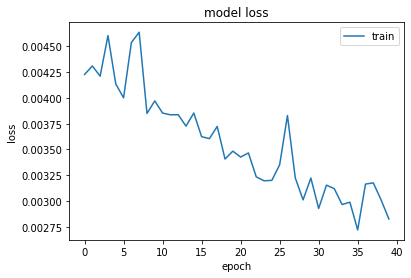

In [20]:
#Plot the training Loss

plt.plot(hist.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'],loc='upper right')
plt.show()

In [33]:
train_data = data.iloc[:1000,:]
test_data = data.iloc[1000:,:]
total_data = pd.concat((train_data,test_data),axis=0)

In [34]:
inputs = total_data[len(total_data)-len(test_data)-60:].values

In [35]:
inputs.shape

(464, 1)

In [36]:
inputs = inputs.reshape(-1,1)

In [37]:
inputs = scaler.transform(inputs)

In [38]:
x_test = []
for i in range(60,464):
  x_test.append(inputs[i-60:i,0])

In [39]:
x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [40]:
x_test.shape

(404, 60, 1)

In [41]:
#Make Predictions

predicted_price = model.predict(x_test)
predicted_price = scaler.inverse_transform(predicted_price)

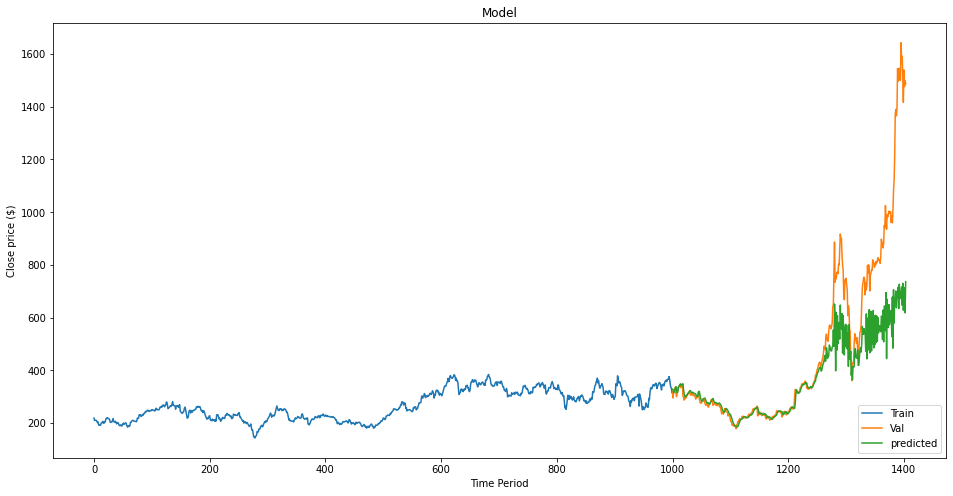

In [44]:
#Visualization

train = data[:1000]
valid = data[1000:]
valid['predicted']=predicted_price
plt.figure(figsize=(16,8))
plt.title('Model')
plt.ylabel('Close price ($)')
plt.xlabel('Time Period')
plt.plot(train['Close'])
plt.plot(valid[['Close','predicted']])
plt.legend(['Train','Val','predicted'],loc='lower right')
plt.show()

In [45]:
print(valid)

            Close   predicted
1000   319.769989  328.938171
1001   295.390015  326.488617
1002   326.089996  315.798187
1003   316.130005  322.686737
1004   333.869995  325.844757
...           ...         ...
1399  1417.000000  628.597717
1400  1539.599976  700.003052
1401  1476.489990  713.548462
1402  1499.109985  618.447205
1403  1487.489990  736.688843

[404 rows x 2 columns]
